<font size="+3"><strong>Predicting Price with Neighborhood</strong></font>

In [46]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

In [47]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names",inplace=True)

    return df

Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate XLSX files in the `data` directory. Assign this list to the variable name `files`.

In [48]:
files = glob("buenos-aires-real-estate-*.xlsx")
files

['buenos-aires-real-estate-1.xlsx',
 'buenos-aires-real-estate-2.xlsx',
 'buenos-aires-real-estate-3.xlsx',
 'buenos-aires-real-estate-4.xlsx',
 'buenos-aires-real-estate-5.xlsx']

Use the `wrangle` function in a `for` loop to create a list named `frames`. The list should the cleaned DataFrames created from the XLSX filenames  collected in `files`.

In [49]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)


In [50]:
frames[0].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1.697368e+16,1.842857e+15,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1.812500e+03,2.071429e+15,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2.185185e+15,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1.357143e+15,1.357143e+15,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1.578947e+16,1.800000e+03,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [51]:
# Check the work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate the items in `frames` into a single DataFrame `df`. Set the `ignore_index` argument to `True`.


In [52]:
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1.697368e+16,1.842857e+15,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1.812500e+03,2.071429e+15,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2.185185e+15,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1.357143e+15,1.357143e+15,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1.578947e+16,1.800000e+03,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [53]:
df.shape

(6582, 17)

## Explore

Modify the `wrangle` function to create a new feature `"neighborhood"`. Neighborhood for each property is located in the `"place_with_parent_names"` column. For example, a property with the place name `"|Argentina|Capital Federal|Palermo|"` is located in the neighborhood is `"Palermo"`. Also, the function should drop the `"place_with_parent_names"` column.

In [54]:
# Check the work
assert df.shape == (6582, 17), f"`df` is the wrong size: {df.shape}."
assert (
        "place_with_parent_names" not in df
), 'Remember to remove the `"place_with_parent_names"` column.'

## Split

Create the feature matrix `X_train` and target vector `y_train`. `X_train` should contain one feature: `"neighborhood"`. The target is `"price_aprox_usd"`.

In [55]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [56]:
# Check the work
assert X_train.shape == (6582, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model

## Baseline

Calculate the baseline mean absolute error for the model.

In [57]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.83701458527
Baseline MAE: 44860.10834274134


## Iterate

First, instantiate a `OneHotEncoder` named `ohe`. Set the `use_cat_names` argument to `True`. Next, fit the transformer to the feature matrix `X_train`. Use the encoder to transform the feature matrix `X_train`, and assign the transformed data to the variable `XT_train`.


In [58]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)
# Fit
ohe.fit(X_train)
# Transform

XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LinearRegression` predictor. Then fit the model to the training data.

In [59]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [60]:
# Check the work
check_is_fitted(model[-1])

## Evaluate

First, create a list of predictions for the observations in the feature matrix `X_train`. Name this list `y_pred_training`. Then calculate the training mean absolute error for the predictions in `y_pred_training` as compared to the true targets in `y_train`.

In [61]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


Import the test data `buenos-aires-test-features.xlsx` into a DataFrame and generate a Series of predictions using the model.

In [62]:
X_test = pd.read_excel("buenos-aires-test-features.xlsx")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

# Communicate Results

Write out the equation for the model, it'll be too big to fit on the screen. That's because, when I used the `OneHotEncoder` to encode the neighborhood data, I created a much wider DataFrame, and each column/feature has its own coefficient in my model's equation.

<center><img src="Equation 3.png" alt="Equation: y = β0 + β1 x1 + β2 x2 + ... + β59 x59 + β60 x60 " style="width: 800px;"/></center>

This is a **high-dimensional** model. Instead of a 2D or 3D plot, I'd need a 58-dimensional plot to represent it, which is impossible! I'll need to extract and represent the information for my equation a little differently than before.

Extract the intercept and coefficients for the model.

In [63]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


Extract the feature names of the encoded data from the `OneHotEncoder` in the model.

In [64]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita', 'neighborhood_Villa Luro', 'neighborhood_Caballito', 'neighborhood_Constitución', 'neighborhood_Once']


In [65]:
# Check the work
assert isinstance(
    feature_names, list
), f"`features` should be a `list`, not {type(features)}."
assert len(feature_names) == len(
    coefficients
), "You should have the same number of features and coefficients."

Create a pandas Series named `feat_imp` where the index is the `features` and the values are the `coefficients`.

In [66]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

In [67]:
# Check the work
assert isinstance(
    feat_imp, pd.Series
), f"`feat_imp` should be a `float`, not {type(feat_imp)}."
assert feat_imp.shape == (57,), f"`feat_imp` is wrong shape: {feat_imp.shape}."
assert all(
    a == b for a, b in zip(sorted(feature_names), sorted(feat_imp.index))
), "The index of `feat_imp` should be identical to `features`."

Print the equation that the model has determined for predicting apartment price based on longitude and latitude.

In [68]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-2898.96 * neighborhood_Chacarita)
+ (-6.3 * neighborhood_Villa Luro)
+ (9252.89 * neighborhood_Caballito)
+ (-41748.73 * neighborhood_Constitución)
+ (-3230.37 * neighborhood_Once)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-8662.28 * neighborhood_Flores)
+ (46954.21 * neighborhood_Belgrano)
+ (-13729.1 * neighborhood_Liniers)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-10678.63 * neighborhood_San Cristobal)
+ (-7974.66 * neighborhood_Congreso)
+ (14701.16 * neighborhood_Saavedra)
+ (-11172.55 * neighborhood_Balvanera)
+ (-29585.61 * neighborhood_Parque Avellaneda)
+ (72740.78 * neighborhood_Recoleta)
+ (5638.47 * neighborhood_San Telmo)
+ (42831.32 * neighborhood_Nuñez)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-6323.68 * neighborhood_Parque Centenario)
+ (4330.55 * neighborhood_Abasto)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-19370.74 * neighborhood_)
+ (-7108.23 * neighborhood_Paternal)
+ (-21078.78 * neighborhood_Ma

Create a horizontal bar chart that shows the top 15 coefficients for the model, based on their absolute value.

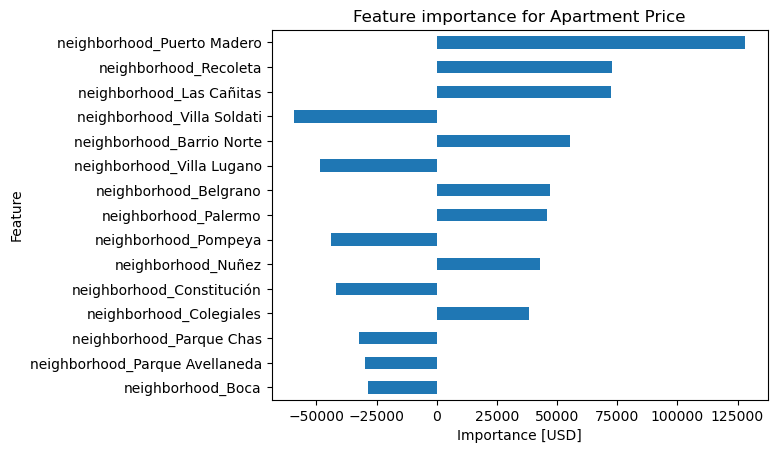

In [69]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature importance for Apartment Price");